# Importing Necessary Libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Creating The Model

In [2]:
#Critic
class Critic(nn.Module):
    def __init__(self,channels_img,features_c):
        super(Critic,self).__init__()
        self.critic = nn.Sequential(
            #Input: batch_size*channels_img*64*64
            nn.Conv2d(channels_img,features_c,kernel_size=4,stride=2,padding=1), #32*32
            nn.LeakyReLU(0.2),
            self.block(features_c,features_c*2,4,2,1), #16*16
            self.block(features_c*2,features_c*4,4,2,1), #8*8
            self.block(features_c*4,features_c*8,4,2,1), #4*4
            nn.Conv2d(features_c*8,1,kernel_size=4,stride=2,padding=0), #1*1
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.critic(x)

#Generator
class Generator(nn.Module):
    def __init__(self,noise_dim,channels_img,features_g):
        super(Generator,self).__init__()
        self.gen = nn.Sequential(
            #Input: batch_size*noise_dim*1*1
            self.block(noise_dim,features_g*16,4,1,0), #batch_size*f_g*16*4*4
            self.block(features_g*16,features_g*8,4,2,1), #batch_size*f_g*8*8*8
            self.block(features_g*8,features_g*4,4,2,1), #batch_size*f_g*4*16*16
            self.block(features_g*4,features_g*2,4,2,1), #batch_size*f_g*2*32*32
            nn.ConvTranspose2d(features_g*2,channels_img,kernel_size=4,stride=2,padding=1),#batch_size*channel_img*64*64
            nn.Tanh()
        )
    def block(self,in_channels,out_channels,kernel_size,stride,padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),#we don't need bias as we are using batchnorm
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self,x):
        return self.gen(x)


# Initializing The Model Weights 

In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m,(nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data,0.0,0.02) #0 mean and .02 std

# Hyperparameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 5e-5
noise_dim = 100
img_size = 64
batch_size = 64
num_epochs = 50
channels_img = 1
features_c = 64
features_g = 64
critic_epochs = 5
wt_clip = 0.01

# Dataset MNIST

In [5]:
composed_transforms = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * channels_img, std=[0.5] * channels_img)
    ]
)
dataset = datasets.MNIST(root="dataset/",train=True,transform = composed_transforms, download=True)
dataloader = DataLoader(dataset,batch_size = batch_size,shuffle =True)

100%|██████████| 9912422/9912422 [00:00<00:00, 116770289.44it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43216444.46it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39427906.67it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 9794616.33it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# Initialization

In [6]:
gen = Generator(noise_dim,channels_img,features_g).to(device)
cri = Critic(channels_img,features_c).to(device)
initialize_weights(gen)
initialize_weights(cri)
opt_gen = optim.RMSprop(gen.parameters(),lr = lr)
opt_cri= optim.RMSprop(cri.parameters(),lr = lr)
fixed_noise = torch.randn(32,noise_dim,1,1).to(device)

# Training

Epoch 1/50: 100%|██████████| 938/938 [05:35<00:00,  2.80batch/s, C_loss=-1.52, G_loss=0.724]


Epoch [1/50], Avg Critic Loss: -1.5221, Avg Generator Loss: 0.7240


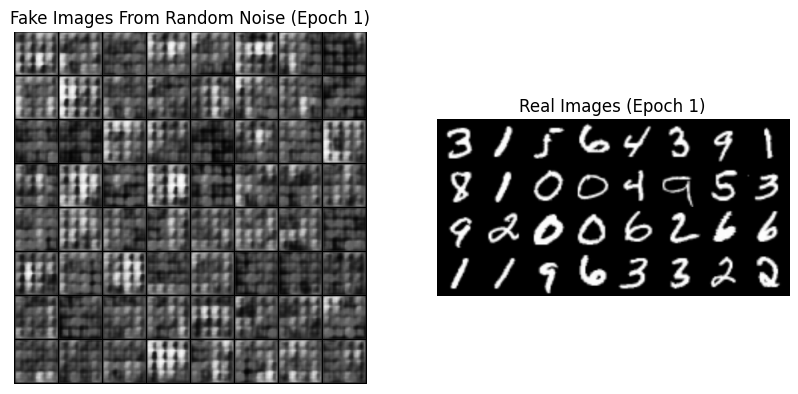

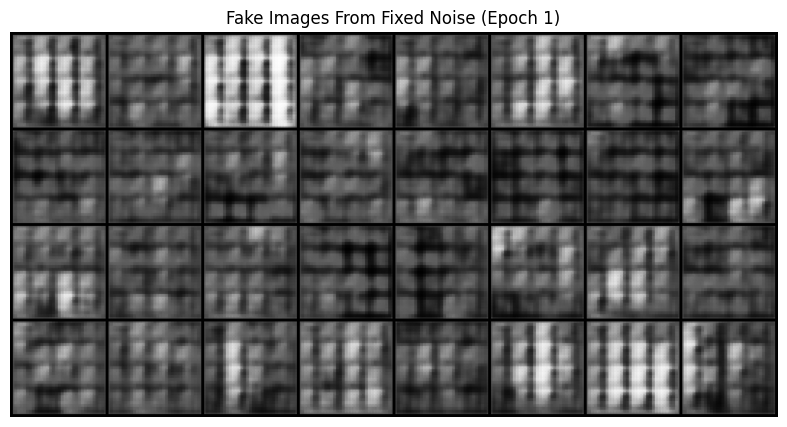

Epoch 2/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-1.53, G_loss=0.724]


Epoch [2/50], Avg Critic Loss: -1.5277, Avg Generator Loss: 0.7244


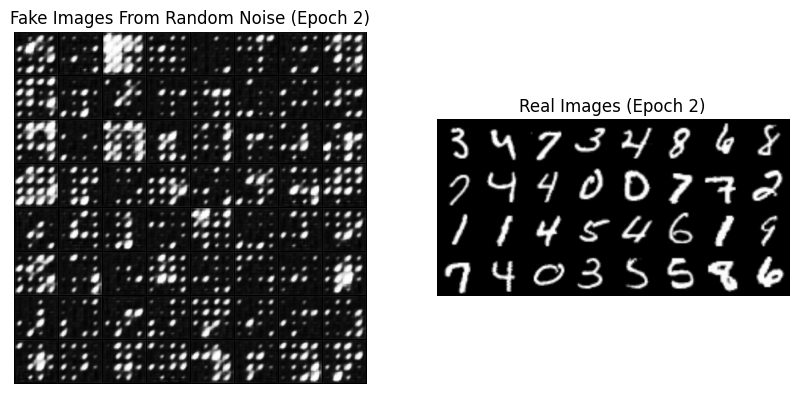

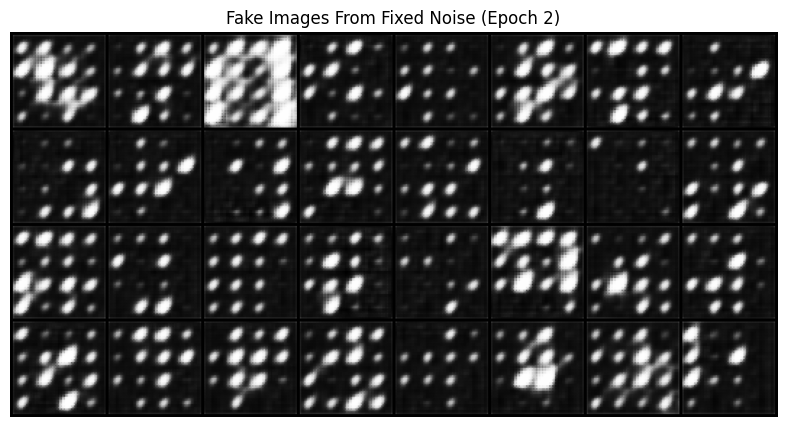

Epoch 3/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-1.32, G_loss=0.63] 


Epoch [3/50], Avg Critic Loss: -1.3239, Avg Generator Loss: 0.6304


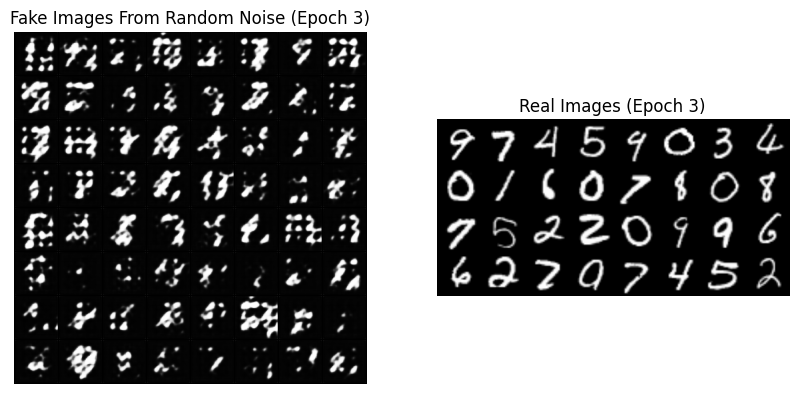

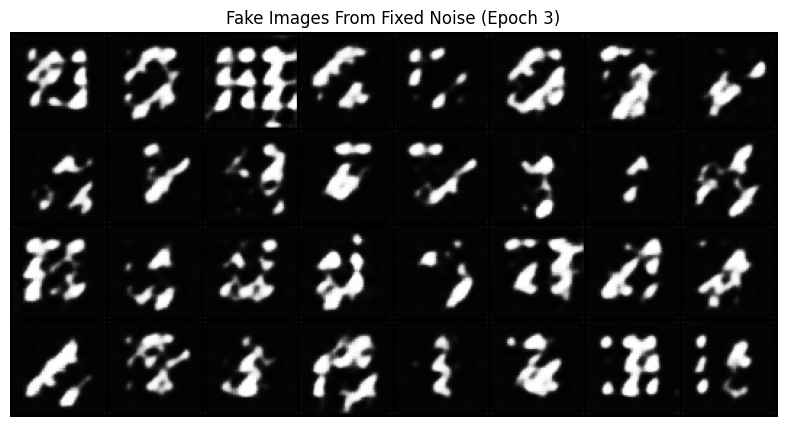

Epoch 4/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-1.02, G_loss=0.491]


Epoch [4/50], Avg Critic Loss: -1.0195, Avg Generator Loss: 0.4910


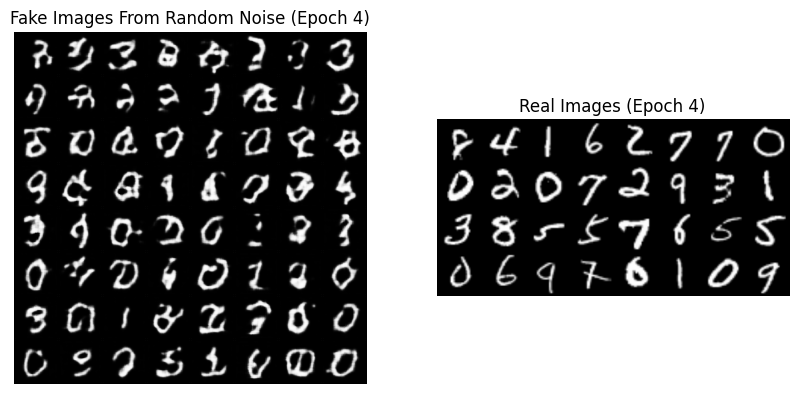

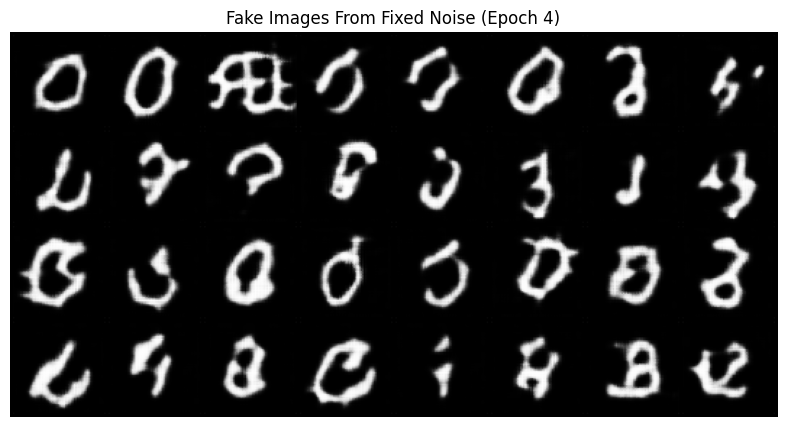

Epoch 5/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-1.01, G_loss=0.479]


Epoch [5/50], Avg Critic Loss: -1.0059, Avg Generator Loss: 0.4792


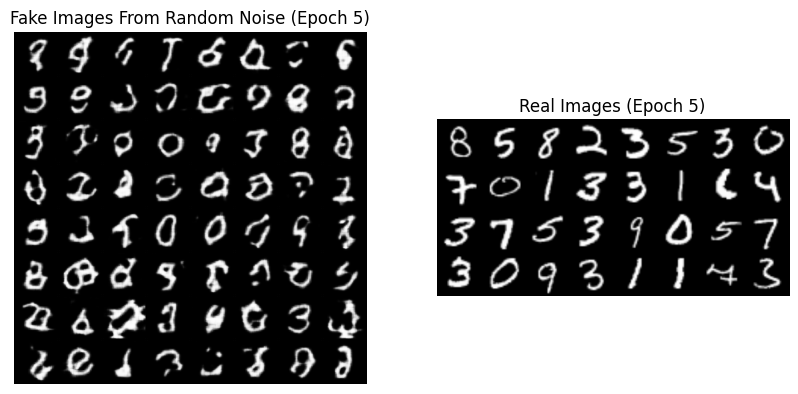

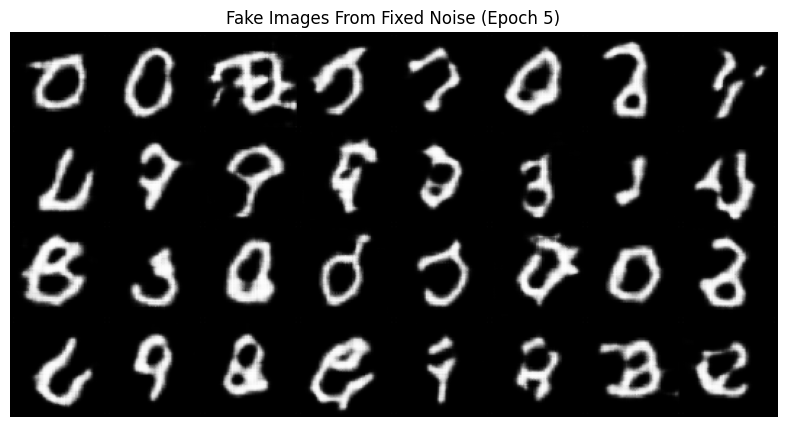

Epoch 6/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-1.02, G_loss=0.486]


Epoch [6/50], Avg Critic Loss: -1.0169, Avg Generator Loss: 0.4861


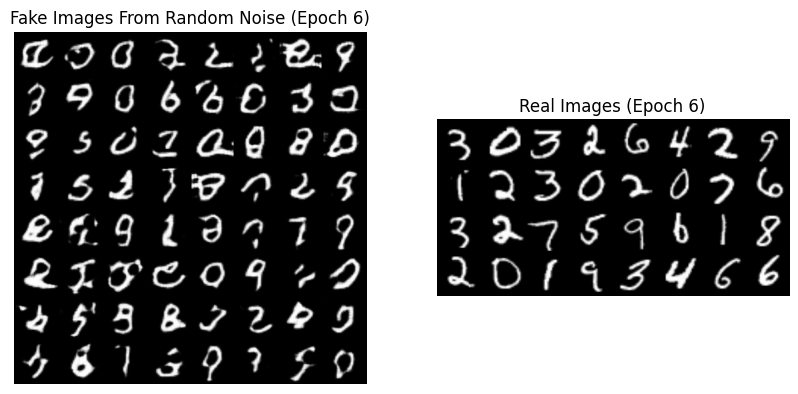

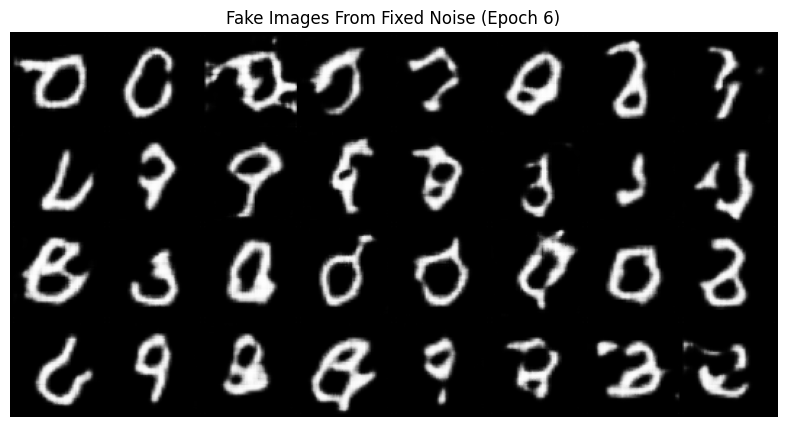

Epoch 7/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.995, G_loss=0.476]


Epoch [7/50], Avg Critic Loss: -0.9949, Avg Generator Loss: 0.4760


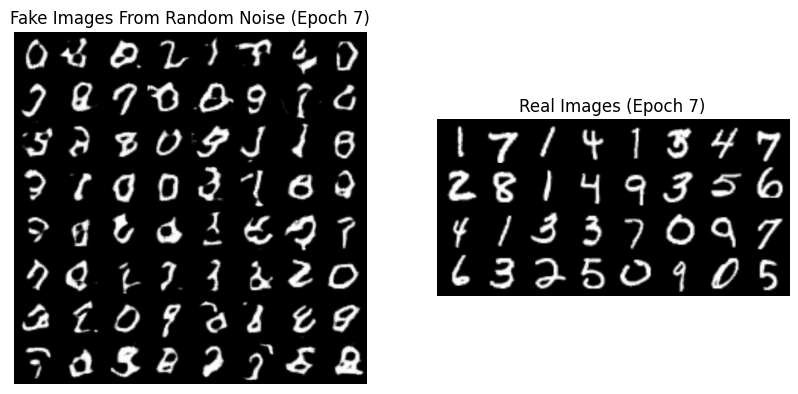

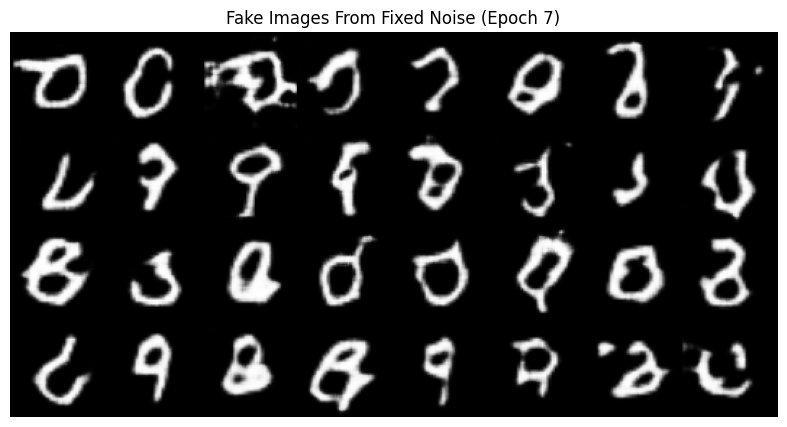

Epoch 8/50: 100%|██████████| 938/938 [05:33<00:00,  2.82batch/s, C_loss=-.967, G_loss=0.46] 


Epoch [8/50], Avg Critic Loss: -0.9669, Avg Generator Loss: 0.4604


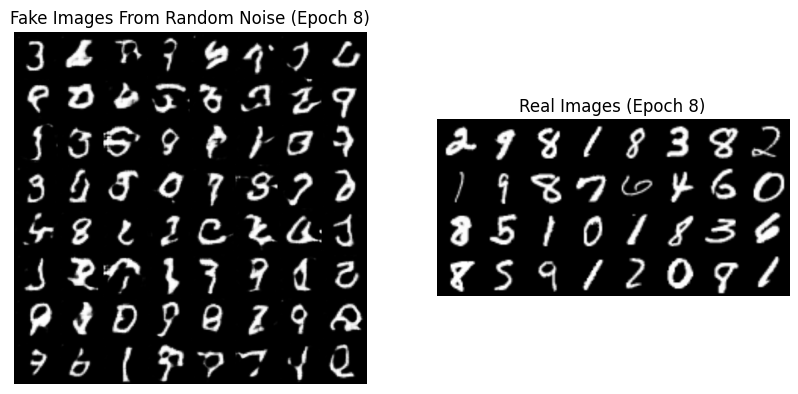

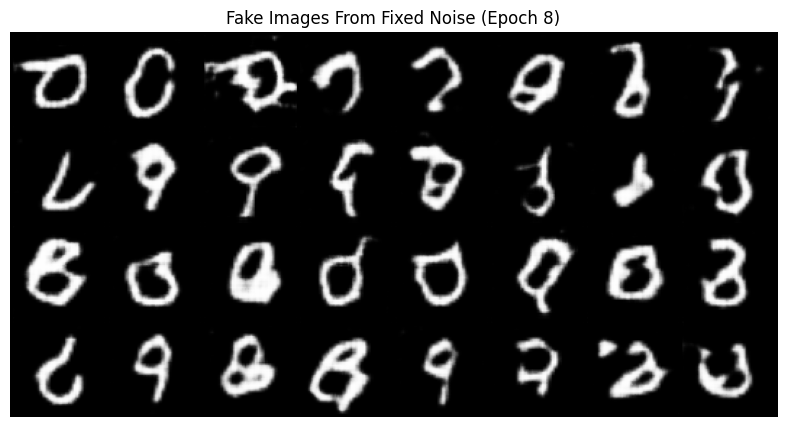

Epoch 9/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.938, G_loss=0.449]


Epoch [9/50], Avg Critic Loss: -0.9378, Avg Generator Loss: 0.4489


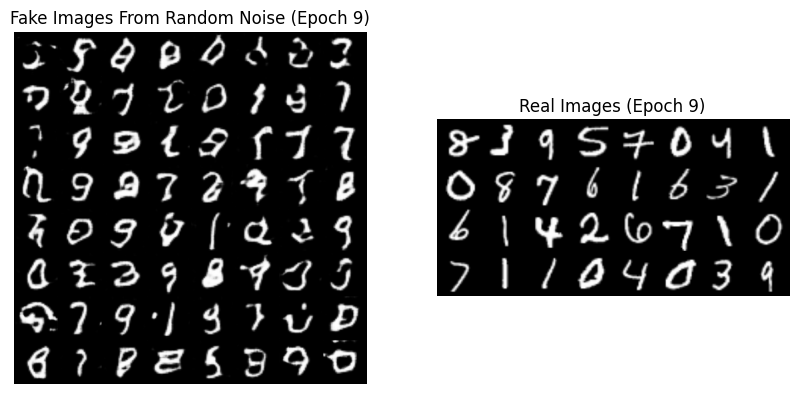

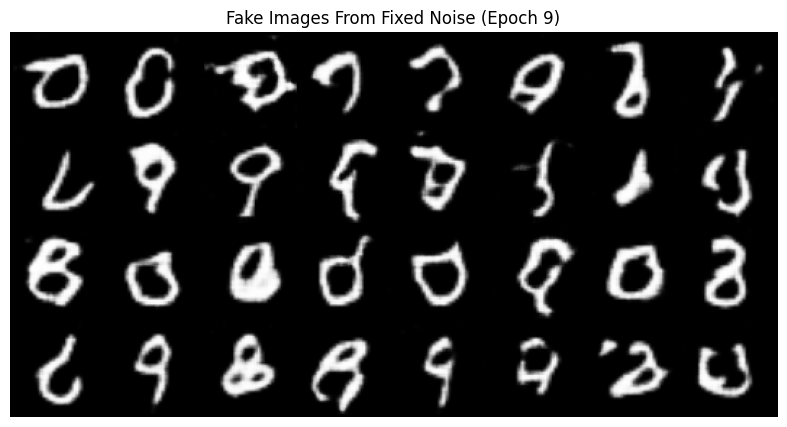

Epoch 10/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.91, G_loss=0.44]  


Epoch [10/50], Avg Critic Loss: -0.9105, Avg Generator Loss: 0.4404


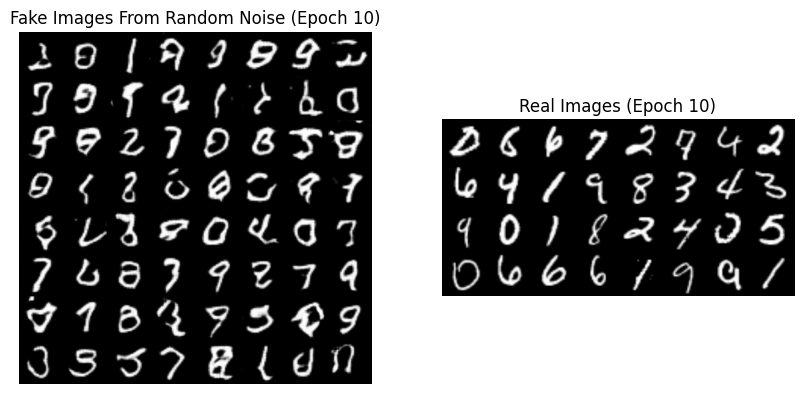

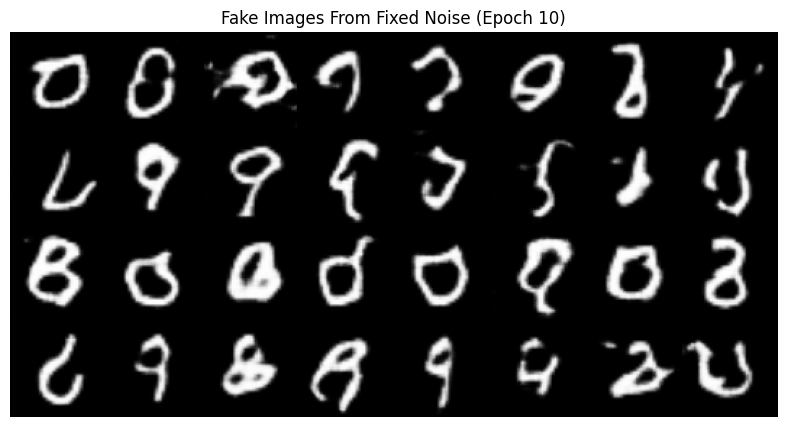

Epoch 11/50: 100%|██████████| 938/938 [05:32<00:00,  2.82batch/s, C_loss=-.88, G_loss=0.428] 


Epoch [11/50], Avg Critic Loss: -0.8796, Avg Generator Loss: 0.4281


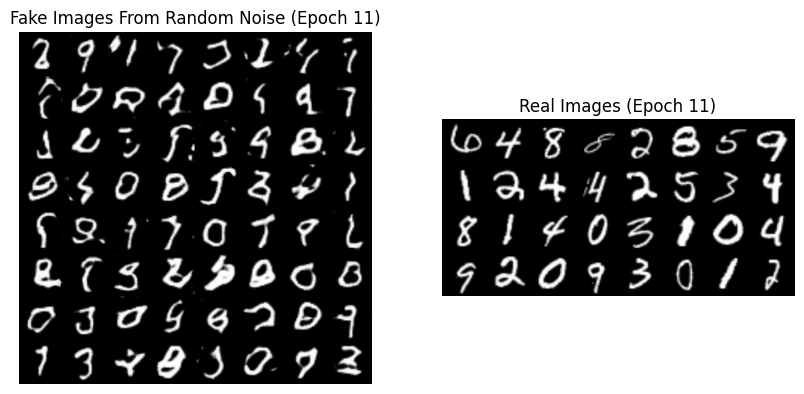

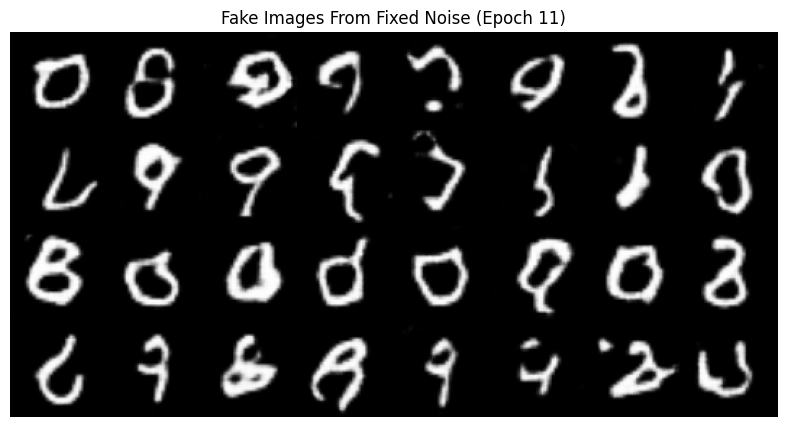

Epoch 12/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.857, G_loss=0.421]


Epoch [12/50], Avg Critic Loss: -0.8570, Avg Generator Loss: 0.4206


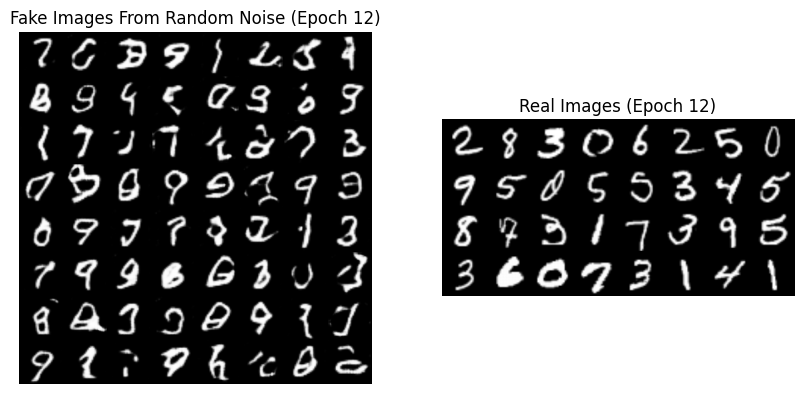

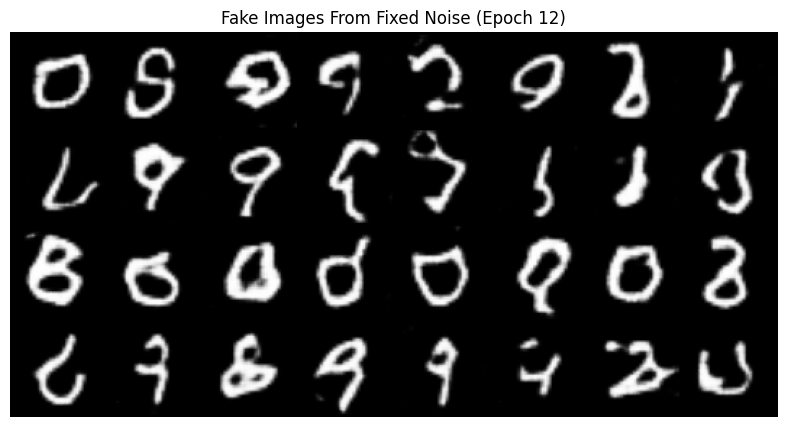

Epoch 13/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.834, G_loss=0.411]


Epoch [13/50], Avg Critic Loss: -0.8344, Avg Generator Loss: 0.4114


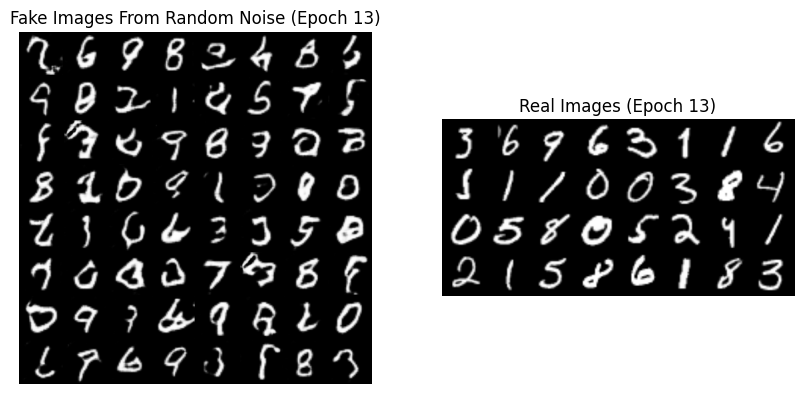

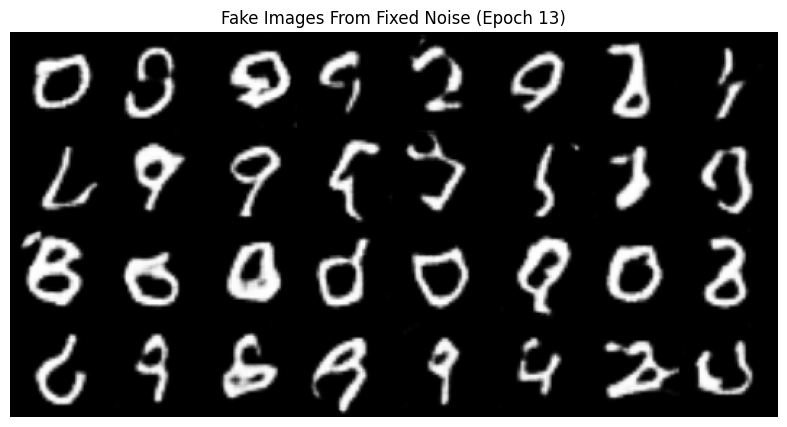

Epoch 14/50: 100%|██████████| 938/938 [05:32<00:00,  2.82batch/s, C_loss=-.815, G_loss=0.404]


Epoch [14/50], Avg Critic Loss: -0.8154, Avg Generator Loss: 0.4042


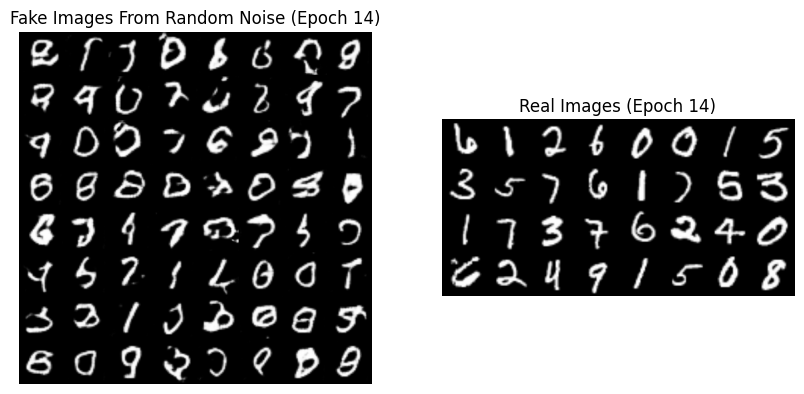

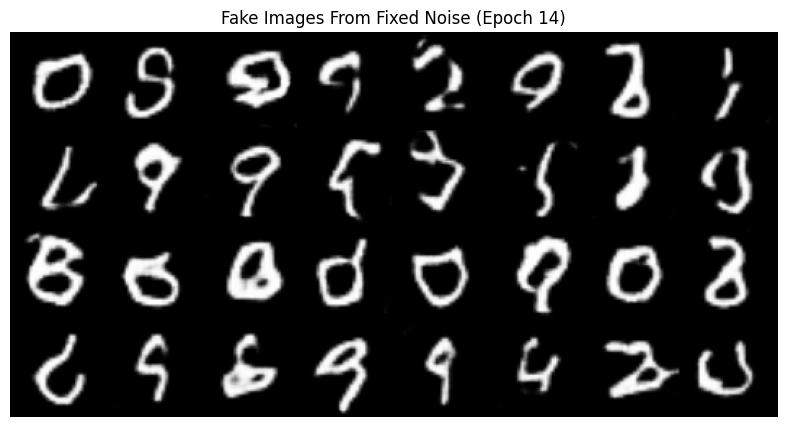

Epoch 15/50: 100%|██████████| 938/938 [05:32<00:00,  2.82batch/s, C_loss=-.799, G_loss=0.398]


Epoch [15/50], Avg Critic Loss: -0.7986, Avg Generator Loss: 0.3976


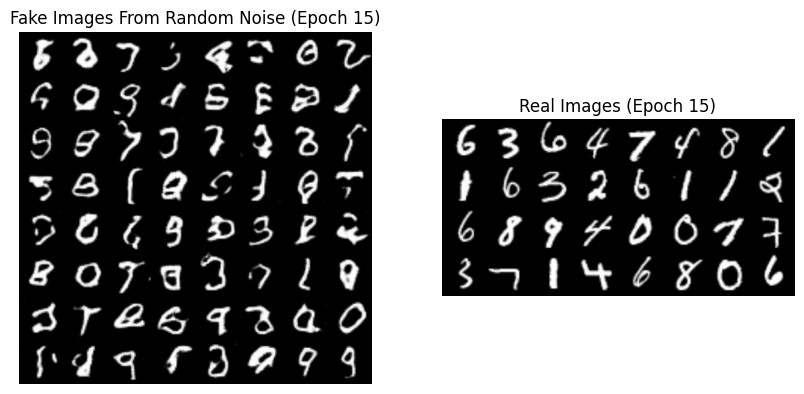

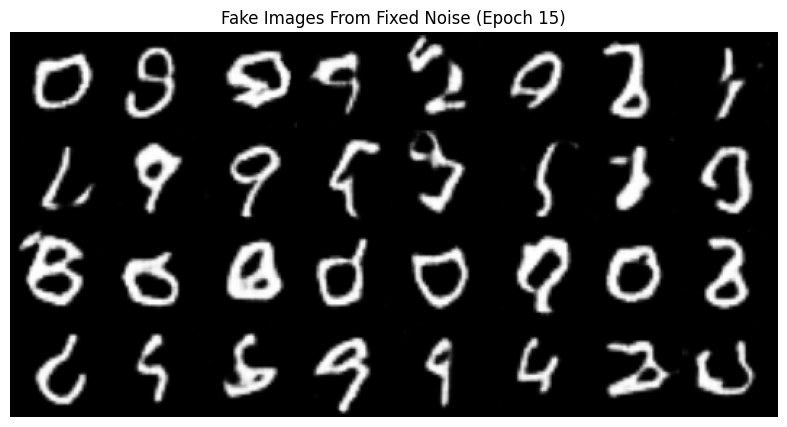

Epoch 16/50: 100%|██████████| 938/938 [05:32<00:00,  2.82batch/s, C_loss=-.783, G_loss=0.392]


Epoch [16/50], Avg Critic Loss: -0.7828, Avg Generator Loss: 0.3921


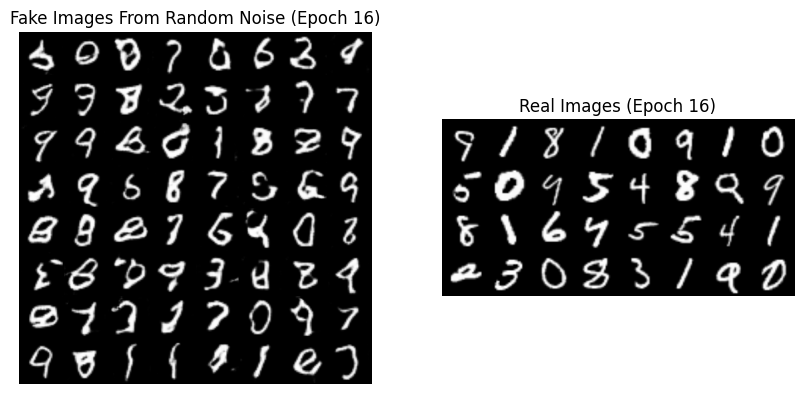

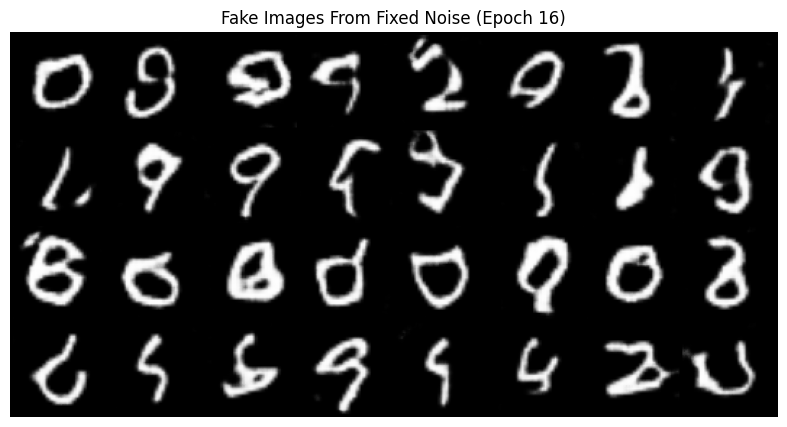

Epoch 17/50: 100%|██████████| 938/938 [05:33<00:00,  2.82batch/s, C_loss=-.767, G_loss=0.388]


Epoch [17/50], Avg Critic Loss: -0.7667, Avg Generator Loss: 0.3883


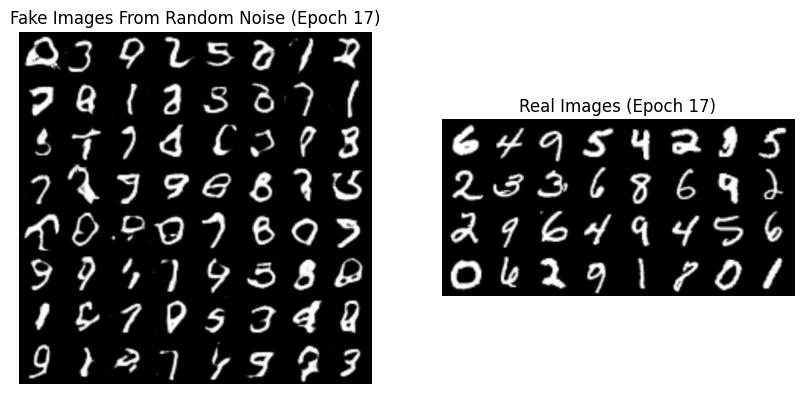

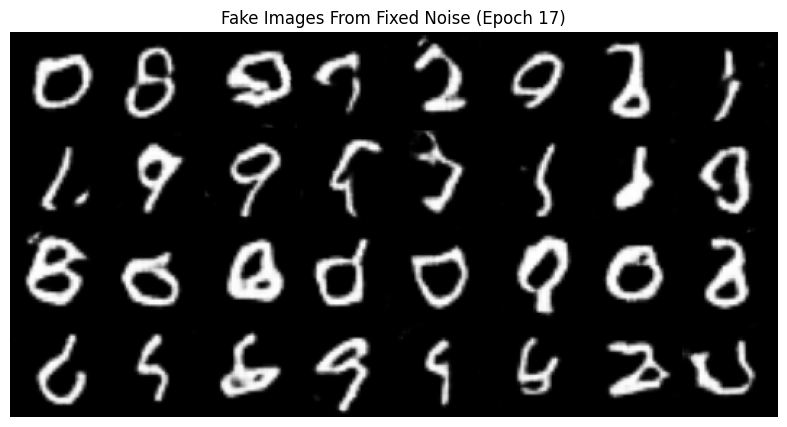

Epoch 18/50:  48%|████▊     | 448/938 [02:39<02:54,  2.81batch/s, C_loss=-.757, G_loss=0.384]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Epoch 19/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.736, G_loss=0.376]


Epoch [19/50], Avg Critic Loss: -0.7359, Avg Generator Loss: 0.3759


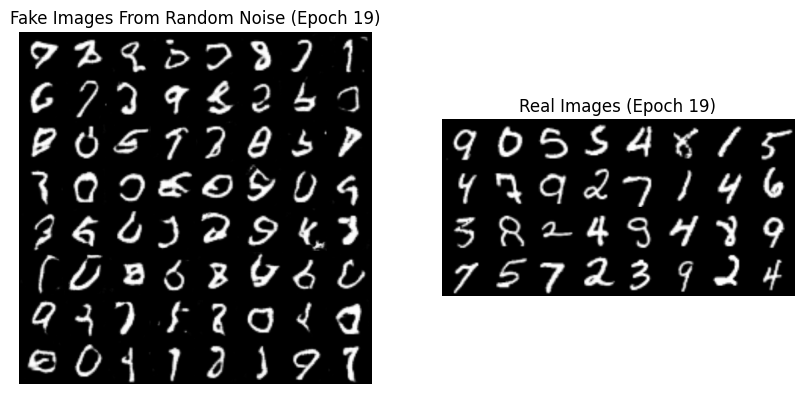

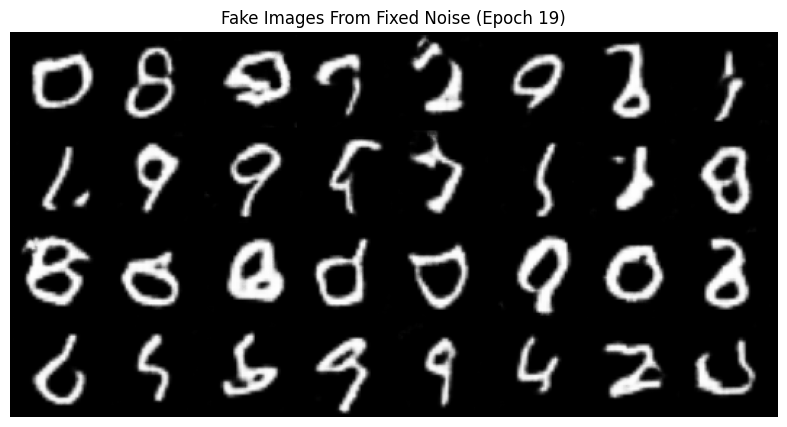

Epoch 20/50: 100%|██████████| 938/938 [05:33<00:00,  2.81batch/s, C_loss=-.721, G_loss=0.371]


Epoch [20/50], Avg Critic Loss: -0.7214, Avg Generator Loss: 0.3713


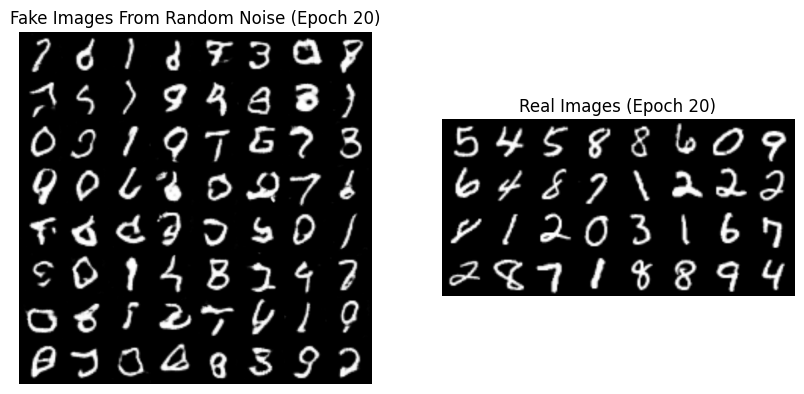

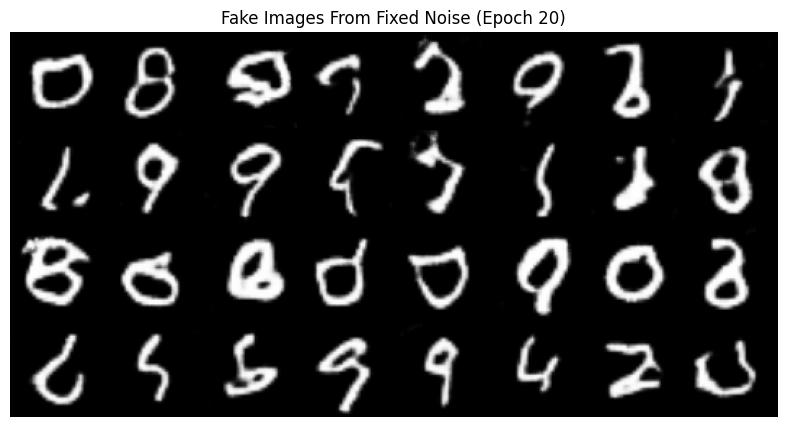

Epoch 21/50: 100%|██████████| 938/938 [05:33<00:00,  2.82batch/s, C_loss=-.707, G_loss=0.364]


Epoch [21/50], Avg Critic Loss: -0.7071, Avg Generator Loss: 0.3641


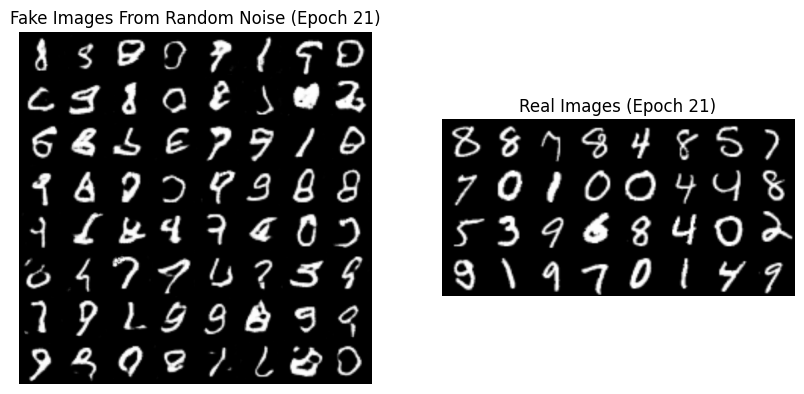

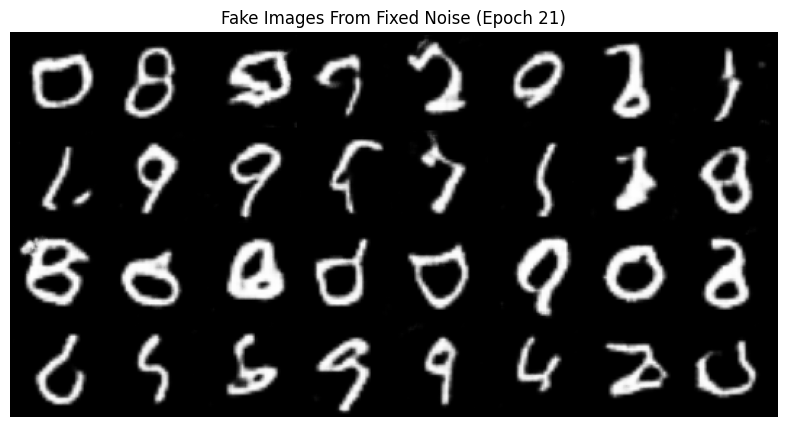

Epoch 22/50: 100%|██████████| 938/938 [05:33<00:00,  2.82batch/s, C_loss=-.694, G_loss=0.359]


Epoch [22/50], Avg Critic Loss: -0.6940, Avg Generator Loss: 0.3589


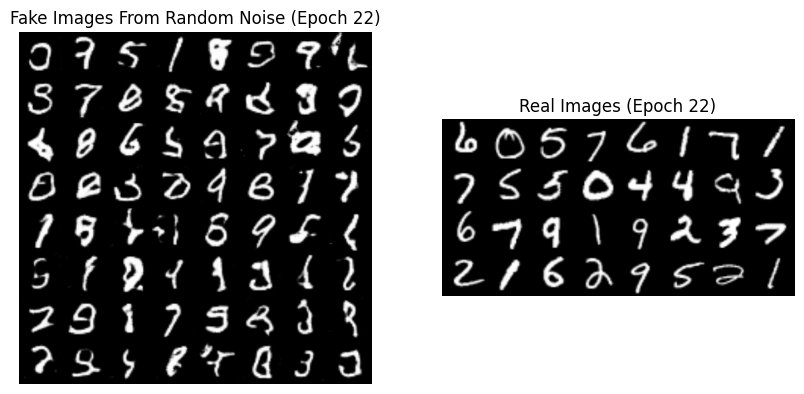

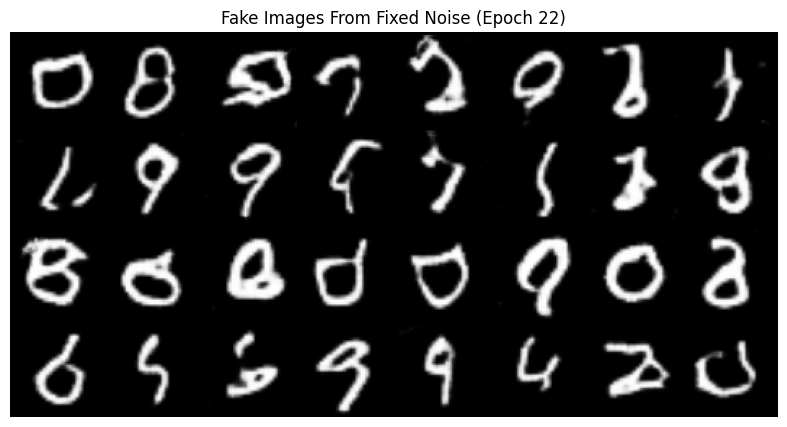

Epoch 23/50: 100%|██████████| 938/938 [05:33<00:00,  2.82batch/s, C_loss=-.682, G_loss=0.354]


Epoch [23/50], Avg Critic Loss: -0.6816, Avg Generator Loss: 0.3540


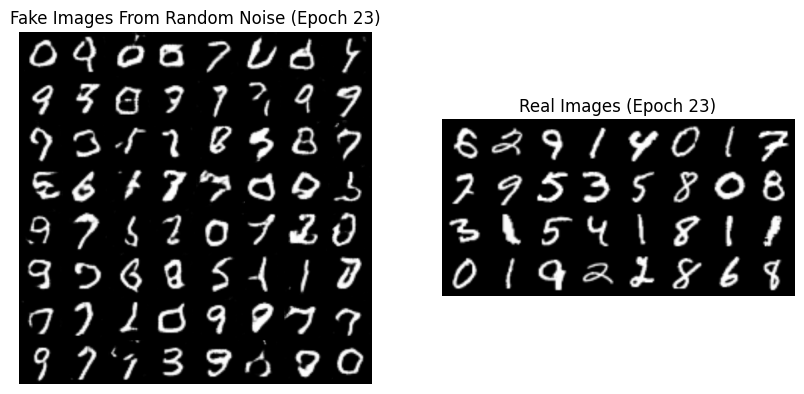

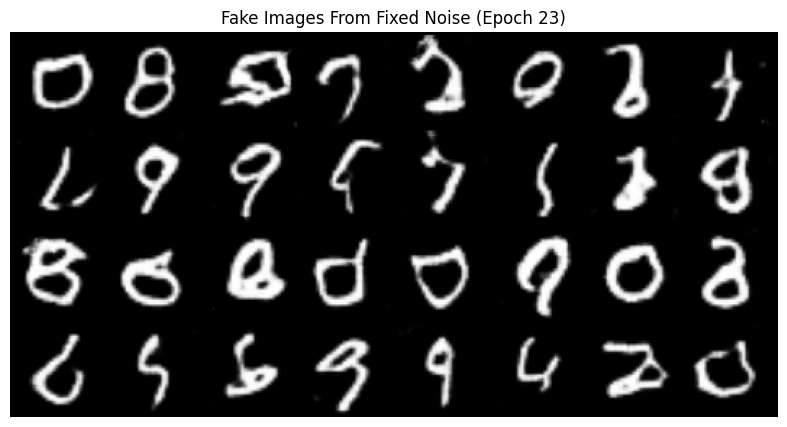

Epoch 24/50:  57%|█████▋    | 535/938 [03:10<02:22,  2.82batch/s, C_loss=-.672, G_loss=0.351]

In [ ]:
# %%time
output_dir = "/kaggle/working/images"
# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
gen_loss = []
cri_loss = []
gen.train()
cri.train()
for epoch in range(num_epochs):
    total_lossC = 0.0
    total_lossG = 0.0
    
    # Create tqdm progress bar
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        for batch_idx, (real_img, label) in t:
            real_img = real_img.to(device)
            
            intermediate_lossC = 0.0
            #Train Discriminator: min -[E[critic(real)]-E[critic(gen_fake)]]
            for _ in range(critic_epochs):
                noise = torch.randn(batch_size, noise_dim,1,1).to(device)
                fake_img = gen(noise)
                cri_real = cri(real_img).reshape(-1)
                cri_fake = cri(fake_img).reshape(-1)
                lossC = -(torch.mean(cri_real) - torch.mean(cri_fake))
                opt_cri.zero_grad()
                lossC.backward(retain_graph = True)
                opt_cri.step()
                
                #Gradient Clipping
                for p in cri.parameters():
                    p.data.clamp_(-wt_clip,wt_clip)
                    
                intermediate_lossC += lossC.item()
                
            intermediate_lossC = intermediate_lossC/critic_epochs
                    
            #Train Generator: min -E[critic(gen_fake)]
            output = cri(fake_img).reshape(-1)
            lossG = -torch.mean(output)
            opt_gen.zero_grad()
            lossG.backward()
            opt_gen.step()
            
            # Accumulate losses
            total_lossC += intermediate_lossC
            total_lossG += lossG.item()
            
            # Update tqdm description with current losses
            t.set_postfix({'C_loss': total_lossC / (batch_idx + 1), 'G_loss': total_lossG / (batch_idx + 1)})
        
    # Compute average losses for the epoch
    avg_lossC = total_lossC/ len(dataloader)
    avg_lossG = total_lossG / len(dataloader)
    cri_loss.append(avg_lossC)
    gen_loss.append(avg_lossG)

    # Print discriminator and generator average losses for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Critic Loss: {avg_lossC:.4f}, Avg Generator Loss: {avg_lossG:.4f}")
    
    #Visualization With Tensorboard
    with torch.no_grad():
        fake_vid = gen(fixed_noise).reshape(-1,1,64,64)
        fake = fake_img.reshape(-1,1,64,64)
        data = real_img.reshape(-1,1,64,64)
        img_grid_fake_vid = torchvision.utils.make_grid(fake_vid,normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
        img_grid_real = torchvision.utils.make_grid(data,normalize=True)
        
        plt.figure(figsize=(10, 5))

        # Plotting the fake images
        plt.subplot(1, 2, 1)
        plt.imshow(torchvision.utils.make_grid(img_grid_fake.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Fake Images From Random Noise (Epoch {epoch+1})")
        plt.axis('off')

        # Plotting the real images
        plt.subplot(1, 2, 2)
        plt.imshow(torchvision.utils.make_grid(img_grid_real.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Real Images (Epoch {epoch+1})")
        plt.axis('off')
        
        # Storing the fake images generated from fixed noise
        plt.figure(figsize=(10, 5))
        plt.imshow(torchvision.utils.make_grid(img_grid_fake_vid.cpu(), normalize=True).permute(1, 2, 0))
        plt.title(f"Fake Images From Fixed Noise (Epoch {epoch+1})")
        plt.axis('off')
        # Save the image
        plt.savefig(os.path.join(output_dir, f"epoch_{epoch+1}.png"))
        
        plt.show()

# Plotting Losses

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting generator loss
plt.subplot(1, 2, 1)
plt.plot(gen_loss, label='Generator Loss', color='blue')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting discriminator loss
plt.subplot(1, 2, 2)
plt.plot(cri_loss, label='Critic Loss', color='orange')
plt.title('Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Converting Generated Images from Fixed Noise to Video

In [ ]:
# Convert images to video
import cv2
import glob

image_files = ['/kaggle/working/images/epoch_1.png',
 '/kaggle/working/images/epoch_2.png',
 '/kaggle/working/images/epoch_3.png',
 '/kaggle/working/images/epoch_4.png',
 '/kaggle/working/images/epoch_5.png',
 '/kaggle/working/images/epoch_6.png',
 '/kaggle/working/images/epoch_7.png',
 '/kaggle/working/images/epoch_8.png',
 '/kaggle/working/images/epoch_9.png',
 '/kaggle/working/images/epoch_10.png',
 '/kaggle/working/images/epoch_11.png',
 '/kaggle/working/images/epoch_12.png',
 '/kaggle/working/images/epoch_13.png',
 '/kaggle/working/images/epoch_14.png',
 '/kaggle/working/images/epoch_15.png',
 '/kaggle/working/images/epoch_16.png',
 '/kaggle/working/images/epoch_17.png',
 '/kaggle/working/images/epoch_18.png',
 '/kaggle/working/images/epoch_19.png',
 '/kaggle/working/images/epoch_20.png',
]

frame = cv2.imread(image_files[0])
height, width, layers = frame.shape

video_name = 'generated_images.avi'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 2, (width, height)) #2->fps

for image_file in image_files:
    video.write(cv2.imread(image_file))

video.release()

print(f"Video saved as {video_name}")